In [ ]:
import re
import scrape_arxiv
import tex_to_json
import analyze_asl_dict
import fine_tune
tex_files_path = "datasets/tex_files/"
json_file_path = "datasets/arxiv_tex.json"
cleaned_json_file_path = "datasets/combined_training_set.json"

In [ ]:
# Step 1: Extract unique arXiv numbers from the asl database
db_path = 'datasets/dict_20231123.db'
arxiv_id_asl_tagged = analyze_asl_dict.extract_unique_arxiv_numbers(db_path)

arxiv_id_asl_tagged.remove('2211.00542') # no tarball available
arxiv_id_asl_tagged.remove('2306.01274') # no tarball available
arxiv_id_asl_tagged.remove('2206.03389') # no tarball available
arxiv_id_asl_tagged.remove('2207.11937') # no tarball available
arxiv_id_asl_tagged.remove('2001.01724') # no tarball available
arxiv_id_asl_tagged.remove('1601.00125') # no tarball available

arxiv_id_asl_tagged.remove('1712.07541') # funky tex file
arxiv_id_asl_tagged.remove('1902.09640') # funky tex file
arxiv_id_asl_tagged.remove('2003.03431') # funky tex file
arxiv_id_asl_tagged.remove('1704.00884') # funky tex file

arxiv_id_asl_tagged = list(set(arxiv_id_asl_tagged))

In [ ]:
# also extract all of my papers

import requests
from bs4 import BeautifulSoup

author = "de_Haan_T"

# Query parameters for the arXiv API
params = {
    'search_query': f'au:{author}',
    'sortBy': 'submittedDate',
    'sortOrder': 'descending',
    'max_results': 5000  # Adjust this number based on your needs
}

# arXiv API endpoint
url = 'http://export.arxiv.org/api/query'

# Request to arXiv API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code != 200:
    raise Exception("Failed to retrieve data from arXiv")

# Parse the response using BeautifulSoup with lxml as the XML parser
soup = BeautifulSoup(response.content, 'lxml')

# Extract arXiv IDs from the response
arxiv_id_tdh = [entry.id.text.split('/')[-1] for entry in soup.find_all('entry')]

# remove the version numbers
arxiv_id_tdh = [re.sub('v[0-9]+', '', arxiv_id) for arxiv_id in arxiv_id_tdh]

In [ ]:
# more arxiv papers recommended for me by asl (but no tags)
arxiv_id_asl_rec = ['2011.08163', '2106.11202', '1907.11976', '1809.00036', '1907.10947', '1407.2973', '1809.00033', '1902.09640', '1911.08047', '2103.16017', '1904.12995', '1809.00032', '1805.03219', '1803.10682', '1910.05748', '2008.12619', '2111.14785', '2012.01709', '2101.01684', '2002.06197', '1905.05777', '2103.06166', '1704.00884', '2308.11608', '1807.02199', '1908.01062', '1907.04473', '1412.4760', '1808.00568', '1408.3161', '1907.08605', '1411.1042', '2006.08061', '2110.00482', '1705.00743', '1412.7521', '2103.13618', '1503.02315', '2208.08559', '2207.11937', '1604.03507', '1708.01360', '1907.09621', '2203.08024', '1909.01305', '1810.10643', '2003.03431', '1712.07541', '1605.00966', '2111.07491', '2310.10849', '1307.2903', '1801.06987', '2012.04047', '2002.05254', '1809.00030', '1701.04396', '1810.02342', '2002.05228', '2106.14797', '2203.16556', '2102.00809', '1706.10286', '2101.06342', '2002.05219', '2012.05934', '2002.05197', '2111.04631', '2102.05033', '2012.04532', '2111.04816', '1907.02156', '1407.3161', '1808.07445', '1810.02441', '1512.07663', '2208.02284', '2111.14751', '1910.07157', '2203.12439', '1607.04668', '1603.06522', '2207.14796', '1808.00567', '2101.12449', '1810.02212', '2111.04633', '2209.09864', '1907.08284', '1311.4953', '2206.10824', '1706.02464', '1910.04121', '2208.01080', '1409.0850', '2203.12440', '1707.09353', '1810.10998', '2202.02773', '2001.01724', '1212.6267', '2111.04778', '2112.02425', '2309.09908', '2212.05642', '1512.07299', '2102.02386', '1601.00125', '1912.04272', '2203.07638', '1908.07642', '2112.03606', '2311.01846', '2203.16567', '1610.02743', '1303.3535', '2210.08038', '2210.08633', '1410.7488', '1608.03025', '2210.05684', '2012.07077', '2210.04117', '1808.00569', '2304.01158', '2012.08547', '2302.05228', '1812.01679', '1810.02322', '2101.05306', '1603.03904', '1602.07384', '2304.05203', '2207.11804', '1808.00570', '2111.11495', '1601.05452', '2110.00483', '1607.06064', '2304.05202', '2204.05869', '2311.04424', '2304.00973', '2310.07657', '2202.01324', '2207.11377', '2307.01258', '1609.05211', '2208.10482', '1805.09346', '2209.12492', '2210.10893', '1912.00860', '2302.04297', '2012.09363', '2206.03389', '2111.07742', '1809.03689', '1407.2942', '1607.04567', '2211.03786', '1407.6894', '1808.00571', '2202.10055', '1607.06861', '2311.07512', '2211.00542', '2204.12503', '1407.7520', '2301.09634', '2012.07862', '1805.00470', '2210.16202', '1502.00619', '1803.01018', '2003.08949', '1807.05995', '1912.12782', '1403.4302', '2201.04507', '1711.02594', '2007.07289', '1907.09035', '2011.03483', '1404.6250', '1710.08456', '1801.06991', '1711.04169', '1407.5928', '2306.05460', '1502.00596', '2108.03316', '2101.02658', '2207.11374', '1808.10491', '2208.02755', '1808.04493', '2111.11301', '1904.01640', '1806.05576', '2112.01458', '2007.07288', '1309.5381', '1807.07496', '1808.10037', '1309.5383', '2010.07998', '2203.07246', '2208.05997', '1909.11569', '1512.04535', '2311.05793', '1810.05216', '1606.01968', '2207.11375', '2207.13737', '1403.3985', '1507.05551', '1501.07911', '2208.10523', '1910.10199', '1606.09396', '2208.14159', '1506.07814', '1802.03822', '2001.07848', '2310.12213', '1510.02809', '1705.02907', '1805.08363', '2101.09608', '2101.11917', '1605.08770', '1705.02523', '1502.00643', '1610.02360', '1601.07923', '1702.07020', '1802.05257', '1510.09217', '1807.01384', '1401.8029', '1707.02981', '2111.09140', '2207.10012', '2311.05583', '1911.11902', '2007.07290', '1809.06556', '1710.04326', '1912.02902', '1809.07373', '2001.02763', '2104.09511', '1911.05717', '2005.06168', '2101.08374', '2207.13204', '1910.02608', '2009.07772', '1908.00480', '2112.00820', '2012.10345', '1807.05215', '1407.2584', '1711.02266', '1312.6645', '1312.6646', '1806.04316', '2009.05557', '2304.05196', '1602.07744', '2304.09166', '2103.02747', '1603.05976', '2103.03154', '1711.02523', '1608.08891', '1405.5524', '1607.05754', '2307.12931', '1605.06569', '1711.10596', '2207.14242', '1605.05329', '2102.02129', '1608.08234', '2112.07656', '1705.00411', '2207.14212', '1607.01825', '1801.02543', '1711.04841', '1403.2369', '1509.02461', '2009.08822', '2101.08373', '2101.10298', '2101.03833', '2303.12345', '1611.09753', '1711.05344', '2004.11601', '2306.08875', '2012.08636', '1908.08057', '1710.11255', '1808.05152', '2111.01797', '1808.01592', '1408.4790', '2209.02708', '2203.02495', '1911.10980', '1707.01488', '1710.02239', '2012.12407', '1808.01349', '1412.0626', '1604.02593', '2002.05771', '1509.06770', '2310.00059', '2101.08410', '2208.02854', '1310.1422', '2209.12672', '1807.00058', '1807.03927', '2001.10465', '2311.00315', '2205.04494', '2102.06092', '1811.06081', '2102.03661', '2208.12604', '1608.06262', '1904.02116', '1709.05600', '1402.3601', '2006.06594', '2010.13800', '1903.07046', '2111.01055', '2004.01139', '1511.05036', '2107.00473', '2009.07591', '2108.01663', '1702.01871', '1311.5388', '1910.07456', '2103.13334', '2007.04325', '1909.13832', '2205.06901', '2011.02449', '1607.03796', '1611.03866', '2212.01370', '2204.01885', '1903.04763', '1509.04714', '2106.12467', '2103.05582']

In [ ]:
# collate all of the arxiv ids
arxiv_ids = arxiv_id_asl_tagged + arxiv_id_tdh + arxiv_id_asl_rec
arxiv_ids = list(set(arxiv_ids))

In [ ]:
# Step 2: Download the .tex files from arXiv
scrape_arxiv.extract_tex(arxiv_ids, tex_files_path)

In [ ]:
# Step 3: Parse the downloaded .tex files and save to JSON
#tex_to_json.detex_files('datasets/tex_files/')
parsed_tex_files = tex_to_json.parse_tex_files(tex_files_path)
tex_to_json.save_to_json(parsed_tex_files, json_file_path)

In [ ]:
# Step 4: Gather the training data

# clean arxiv json data a little more and include multiple copies
num_copies_arxiv = 4
json_data = tex_to_json.load_from_json(json_file_path)
cleaned_data = []
for _ in range(num_copies_arxiv):
    for paper, data_list in json_data.items():
        # remove any sequences enclosed in square brackets (e.g. [1])
        cleaned_data.extend([re.sub(r'\[[^\]]*\]', '', data) for data in data_list])

# add physics Q&A data
physics_questions = tex_to_json.load_from_json('datasets/physics_clean.json')
cleaned_data.extend(physics_questions)
tex_to_json.save_to_json(cleaned_data, cleaned_json_file_path)

In [ ]:
# Step 5: Tokenize the cleaned JSON 
training_data = 'datasets/combined_training_set.json'

In [ ]:
#Step 6: Train the model
fine_tune.fine_tune(pretrained_model_file_path="zephyr-7b-beta",
    training_data=training_data,
    lr=5e-5,
    gradient_clip=1.0,
    num_epochs=1,
    out_dir="zephyr-7b-beta_cosmosage_v1")

2023-12-05 18:57:00.761283: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 18:57:00.794822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 18:57:00.794851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 18:57:00.795971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 18:57:00.801926: I tensorflow/core/platform/cpu_feature_guar

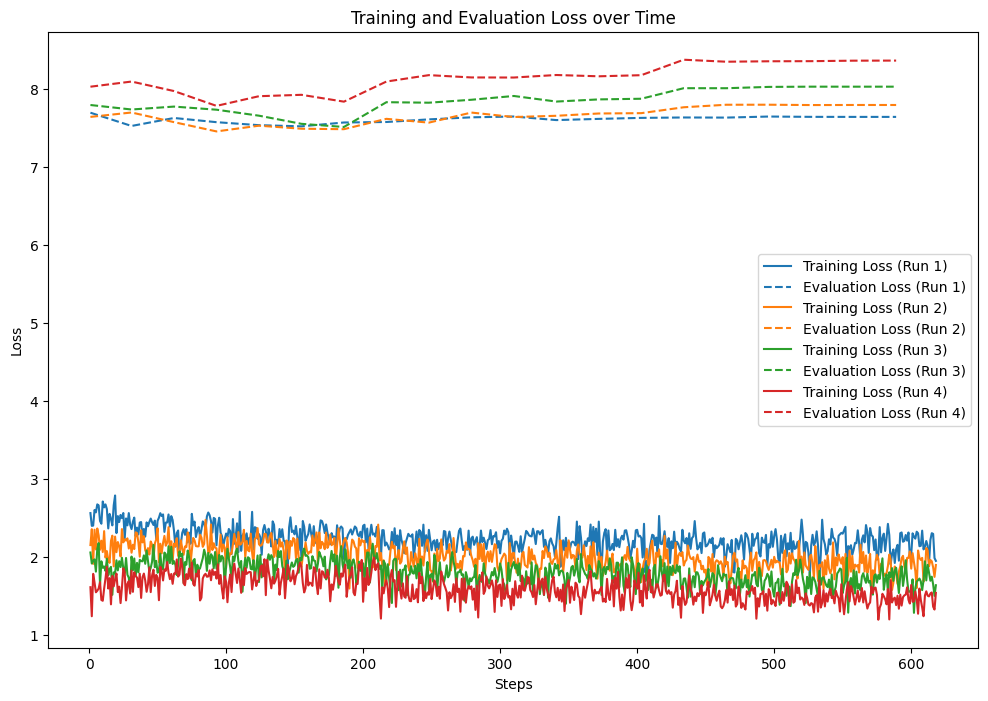

In [1]:
# visualize loss during training
import plot_tf_log
import glob
v5 = glob.glob('models/MiniChat_v5/minichat-out/runs/*/*.0')[0]
v6 = glob.glob('models/MiniChat_v6/minichat-out/runs/*/*.0')[0]
v7 = glob.glob('models/MiniChat_v7/minichat-out/runs/*/*.0')[0]
v8 = glob.glob('models/MiniChat_v8/minichat-out/runs/*/*.0')[0]
v9 = glob.glob('models/MiniChat_v9/minichat-out/runs/*/*.0')[0]
v10 = glob.glob('models/MiniChat_v10/minichat-out/runs/*/*.0')[0]
v11 = glob.glob('models/MiniChat_v11/minichat-out/runs/*/*.0')[0]

plot_tf_log.plot_loss([v8, v9, v10, v11]) # v5, v6, v7, 

In [ ]:
# Step 7: Evaluate the fine-tuned model
import torch
from transformers import pipeline
pipe = pipeline("text-generation", model="/home/tijmen/cosmosage/models/MiniChat_v5/minichat-out",torch_dtype=torch.bfloat16, device_map="auto")
def ask_cosmosage(question):
    messages = [
    #{"role": "system", "content": "You are an AI assistant who is expert at astrophyics, cosmology, cosmic microwave background research, and experimental methods."},
    {"role": "user", "content": f"{question}"}
    ]

    # Apply the chat template
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=512, do_sample=True, temperature=0.6, top_k=50, top_p=0.95)
    answer = outputs[0]["generated_text"].split('<|assistant|>\n')[-1]
    print(np.str(answer))
    return outputs

Let's try using the fine-tuned model as an assistant.

In [ ]:
ask_cosmosage('What is the temperature of the CMB?'); # easy question

In [ ]:
ask_cosmosage('What is Digital Active Nulling?'); # see if it's read the arxiv paper

In [ ]:
ask_cosmosage('Explain the ISW effect.'); # hard question

In [ ]:
# clear VRAM when not using it
del pipe